In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [2]:
df = pd.read_csv("car_fuel_efficiency.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [3]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [4]:
df = df.fillna(0)
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [5]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,4.0,170.0,2770.744260,16.9,2004,Europe,Diesel,Front-wheel drive,0.0,15.865949
1,230,5.0,135.0,2546.670530,11.5,2001,Europe,Gasoline,Front-wheel drive,1.0,17.885965
2,160,4.0,179.0,3845.204498,14.9,2021,Asia,Diesel,All-wheel drive,1.0,10.882701
3,230,5.0,0.0,3006.216277,14.7,2017,Europe,Diesel,All-wheel drive,0.0,14.216032
4,240,1.0,156.0,2436.633616,17.0,2015,Europe,Diesel,Front-wheel drive,1.0,18.016395
...,...,...,...,...,...,...,...,...,...,...,...
1936,200,1.0,171.0,3153.197854,16.1,2006,USA,Diesel,Front-wheel drive,1.0,14.310263
1937,220,3.0,189.0,4049.205206,16.5,2012,Asia,Gasoline,All-wheel drive,0.0,10.164457
1938,210,3.0,171.0,3500.001350,13.4,2022,Asia,Gasoline,All-wheel drive,0.0,13.354373
1939,240,2.0,238.0,2883.491696,13.7,2021,Asia,Diesel,All-wheel drive,0.0,17.038592


In [6]:
y_train = df_train.fuel_efficiency_mpg
y_val = df_val.fuel_efficiency_mpg
y_test = df_test.fuel_efficiency_mpg

del df_train["fuel_efficiency_mpg"]
del df_val["fuel_efficiency_mpg"]
del df_test["fuel_efficiency_mpg"]

In [7]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)

dv.get_feature_names_out()

array(['acceleration', 'drivetrain=All-wheel drive',
       'drivetrain=Front-wheel drive', 'engine_displacement',
       'fuel_type=Diesel', 'fuel_type=Gasoline', 'horsepower',
       'model_year', 'num_cylinders', 'num_doors', 'origin=Asia',
       'origin=Europe', 'origin=USA', 'vehicle_weight'], dtype=object)

In [8]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.get_feature_names_out()))

# vehicle_weight

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [9]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)

print(root_mean_squared_error(y_val, y_val_pred)) # 0.45


0.4599777557336149


In [10]:
ns = np.linspace(10, 200, 20, dtype=int)
scores = []
for n in ns:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_val_pred = rf.predict(X_val)
    score = root_mean_squared_error(y_val, y_val_pred)
    print(n, round(score, 3)) # stops improving at 80?
    scores.append(score)

10 0.46
20 0.454
30 0.451
40 0.448
50 0.446
60 0.445
70 0.445
80 0.445
90 0.445
100 0.444
110 0.443
120 0.444
130 0.443
140 0.443
150 0.443
160 0.443
170 0.443
180 0.442
190 0.443
200 0.443


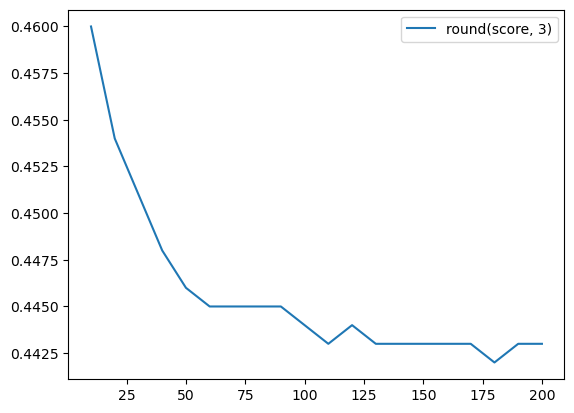

In [11]:
# plt.plot(ns, scores, label="score")
plt.plot(ns, [round(score, 3) for score in scores], label="round(score, 3)")
plt.legend()

In [12]:
ns = np.linspace(10, 200, 20, dtype=int)
max_depths = [10, 15, 20, 25]
means = []

for max_depth in max_depths:
    mean = 0
    for n in ns:
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_val_pred = rf.predict(X_val)
        score = root_mean_squared_error(y_val, y_val_pred)
        mean += score
    mean /= len(ns)
    means.append(mean)
    print(max_depth, mean) # max_depth = 10, best

10 0.44232130237115186
15 0.44505999920137435
20 0.4456441321803527
25 0.44566060000292457


In [13]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
for fi, name in sorted(zip(dv.get_feature_names_out(), rf.feature_importances_), key=lambda x: x[1], reverse=True):
    print(name, fi) # vehicle_weight

0.9591620125325987 vehicle_weight
0.016040214819390435 horsepower
0.011470716492980806 acceleration
0.003269323417164296 engine_displacement
0.003182298414589243 model_year
0.002358670936092339 num_cylinders
0.0015911330645071602 num_doors
0.0005551519590829983 origin=USA
0.0005203580827405701 origin=Europe
0.0004761030460744537 origin=Asia
0.0003818097503064216 drivetrain=All-wheel drive
0.0003436934113118486 fuel_type=Diesel
0.0003366719883675566 fuel_type=Gasoline
0.0003118420847931972 drivetrain=Front-wheel drive


In [14]:
import xgboost as xgb

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [15]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

y_val_pred = model.predict(dval)

root_mean_squared_error(y_val, y_val_pred)

# eta = 0.3 => [14]	train-rmse:0.35025	val-rmse:0.43349
# eta = 0.1 => [61]	train-rmse:0.32953	val-rmse:0.42444

# eta = 0.1 a bit better

[0]	train-rmse:2.28944	val-rmse:2.34561
[1]	train-rmse:2.07396	val-rmse:2.12434
[2]	train-rmse:1.88066	val-rmse:1.92597
[3]	train-rmse:1.70730	val-rmse:1.74987
[4]	train-rmse:1.55163	val-rmse:1.59059
[5]	train-rmse:1.41247	val-rmse:1.44988
[6]	train-rmse:1.28796	val-rmse:1.32329
[7]	train-rmse:1.17660	val-rmse:1.20930
[8]	train-rmse:1.07736	val-rmse:1.10830
[9]	train-rmse:0.98883	val-rmse:1.02009
[10]	train-rmse:0.91008	val-rmse:0.94062
[11]	train-rmse:0.84030	val-rmse:0.87100
[12]	train-rmse:0.77874	val-rmse:0.80916
[13]	train-rmse:0.72417	val-rmse:0.75465
[14]	train-rmse:0.67626	val-rmse:0.70780
[15]	train-rmse:0.63402	val-rmse:0.66672
[16]	train-rmse:0.59690	val-rmse:0.63062
[17]	train-rmse:0.56447	val-rmse:0.60016
[18]	train-rmse:0.53619	val-rmse:0.57383
[19]	train-rmse:0.51138	val-rmse:0.55044
[20]	train-rmse:0.48983	val-rmse:0.53064
[21]	train-rmse:0.47135	val-rmse:0.51451
[22]	train-rmse:0.45501	val-rmse:0.49998
[23]	train-rmse:0.44120	val-rmse:0.48790
[24]	train-rmse:0.42929	va

0.42622800553359225